In [230]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [231]:
def f(x):
  return 3*x**2 - 4*x + 5

In [232]:
f(3.0)

20.0

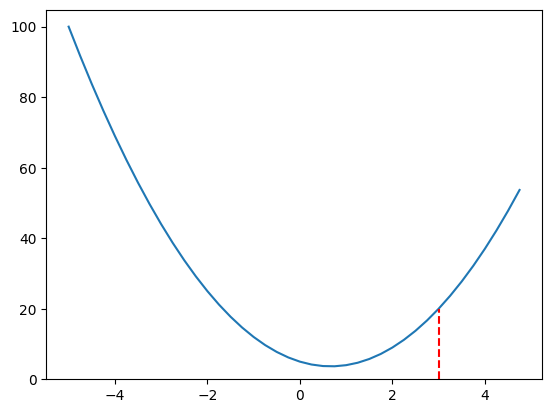

In [233]:
xs = np.arange(-5, 5, 0.25) # -5, -4.75, -4.5, ..., 4.5, 4.75
ys = f(xs) # apply f to each element of xs

plt.plot(xs, ys) # plot the points (xs[i], ys[i])
plt.ylim(ymin=0) # set the y-axis lower bound to 0
# draw a horizontal line at x=3
plt.vlines(3, 0, 20, color='red', linestyles='dashed')

At this point, Andrej reminded us to go back and understand the definition of derivatives.
Derivatives are a fundamental concept in calculus that help us understand how a function changes as we vary its input. In simpler terms, the derivative of a function measures how much the function changes for a small change in its input.

By the definition:

$$
\frac{df}{dx} = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}
$$

He asked us at the point $x=3$, what does the formula above tell us? It simply means if we give a small
nudge $h$ to $x$, how much does the function change? Let's say $h=0.000001$, then before we calculate the derivative, we ask ourselves visually on the graph above, if we add $h$ to $x$, this is shifting right by $h$, how much does the function change by inspection? By inspection, we can easily see that the function output
$f(x+h)$ will be a bit higher than $f(x)$ at $3$. So the derivative is positive, meaning it responds positively to a small change in $x$.

In [234]:
h = 0.000001
x = 3
(f(x + h) - f(x))/h # indeed is close to 14, the theoratical derivative of f at x=3

14.000003002223593

And at $x=\frac{2}{3}$, this is where $f$ is at a minimum, so the derivative is zero. This means
that if we give a small nudge to $x$, the function output will not change at all

In [235]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x))/h

0.0

Now let $d(a, b, c) = a \times b + c$ be a multi-variable function where
$a,b , c$ are variables.

In [236]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


Here is partial differentiation, which is a concept that if your function is a function of multiple variables, you can take the derivative of each variable separately. For example, if we have a function $f(x,y)$, then we can take the derivative of $x$ while holding $y$ constant to get $\frac{\partial f}{\partial x}$. Then this 
simply reduce your problem to a single variable problem, just like previously.

In [237]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

In [238]:
d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [239]:
d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947


In [240]:
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 3.99990001
d2 4.00000001
slope 0.9999999999976694


## Building Micrograd

Note the `Value` class below is analogous to the `Tensor`/`Variable` class in PyTorch.

### Initial Value Class

In [241]:
from typing import Tuple, TypeVar

Val = TypeVar('Val', float, int, np.ndarray)

In [242]:
class Value:
    def __init__(self, data: Val) -> None:
        self.data = data

    def __repr__(self) -> str:
        """Represent the object as a string."""
        return f"Value(data={self.data})"

    def __add__(self, other: Val) -> Val:
        out = Value(data=self.data + other.data)
        return out

    def __mul__(self, other: Val) -> Val:
        out = Value(data=self.data * other.data)
        return out

In [243]:
a = Value(2.0)
b = Value(-3.0)
print(a + b)
print(a.__add__(b))

c = Value(10.0)
d = a * b + c  # recall the example earlier d=ab+c
print(d)
print(a.__mul__(b).__add__(c))

Value(data=-1.0)
Value(data=-1.0)
Value(data=4.0)
Value(data=4.0)


### Children

In [244]:
class Value:
  
    def __init__(self, data: Val, _children: Tuple = ()) -> None:
        self.data = data
        self._prev = set(_children)
    
    def __repr__(self) -> str:
        """Represent the object as a string."""
        return f"Value(data={self.data})"


    def __add__(self, other: Val) -> Val:
        print(self)
        out = Value(data=self.data + other.data, _children=(self, other))
        print(self)
        return out
    
    def __mul__(self, other: Val) -> Val:
        out = Value(data=self.data * other.data, _children=(self, other))
        return out

In [245]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c  # recall the example earlier d=ab+c
print(f"d         =   {d}")
print(f"d._prev   =   {d._prev}")

Value(data=-6.0)
Value(data=-6.0)
d         =   Value(data=4.0)
d._prev   =   {Value(data=-6.0), Value(data=10.0)}


`d._prev` returned the previous value of `d` in the computation graph. More
concretely, `d._prev` calls `set(d._children)` and `_children = (self, other)`
where `self` is the current value and `other` is the other value in the computation.
In our example, `self` is just the value of the expression `a * b` and `other` is the
value of the expression `c`. So `d._prev` returns `{a * b, c}`.

### Operations

We can also add `_op` to the constructor to indicate what operation was done between
the `_prev` two pairs of values. In our example, it should be a "+" operation.

In [246]:
class Value:
    def __init__(self, data: Val, _children: Tuple = (), _op: str = "") -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self) -> str:
        """Represent the object as a string."""
        return f"Value(data={self.data})"

    def __add__(self, other: Val) -> Val:
        out = Value(data=self.data + other.data, _children=(self, other), _op="+")
        return out

    def __mul__(self, other: Val) -> Val:
        out = Value(data=self.data * other.data, _children=(self, other), _op="*")
        return out


In [247]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c  # recall the example earlier d=ab+c
print(f"d         =   {d}")
print(f"d._prev   =   {d._prev}")
print(f"d._op     =   {d._op}")

d         =   Value(data=4.0)
d._prev   =   {Value(data=10.0), Value(data=-6.0)}
d._op     =   +


### Labels

We can also add `_label` to the constructor to indicate what the value is. 

In [248]:
class Value:
    def __init__(
        self, data: Val, _children: Tuple = (), _op: str = "", label: str = ""
    ) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        """Represent the object as a string."""
        return f"Value(data={self.data})"

    def __add__(self, other: Val) -> Val:
        out = Value(data=self.data + other.data, _children=(self, other), _op="+")
        return out

    def __mul__(self, other: Val) -> Val:
        out = Value(data=self.data * other.data, _children=(self, other), _op="*")
        return out

In [249]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a * b + c  # recall the example earlier d=ab+c
d.label = "d"
print(f"d         =   {d}")
print(f"d._prev   =   {d._prev}")
print(f"d._op     =   {d._op}")
print(f"d.label   =   {d.label}")

d         =   Value(data=4.0)
d._prev   =   {Value(data=-6.0), Value(data=10.0)}
d._op     =   +
d.label   =   d


### Grad Attribute

We know that we not only need to forward pass, we need to calculate the gradient of the loss function with respect to the input variables. We can do this by adding a `grad` attribute to the `Value` class.

In [250]:
class Value:
    def __init__(
        self, data: Val, _children: Tuple = (), _op: str = "", label: str = ""
    ) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        self.grad: Val = 0.0

    def __repr__(self) -> str:
        """Represent the object as a string."""
        return f"Value(data={self.data})"

    def __add__(self, other: Val) -> Val:
        out = Value(data=self.data + other.data, _children=(self, other), _op="+")
        return out

    def __mul__(self, other: Val) -> Val:
        out = Value(data=self.data * other.data, _children=(self, other), _op="*")
        return out


In [251]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a * b + c  # recall the example earlier d=ab+c
d.label = "d"
print(f"d         =   {d}")
print(f"d._prev   =   {d._prev}")
print(f"d._op     =   {d._op}")
print(f"d.label   =   {d.label}")
print(f"d.grad    =   {d.grad}")

d         =   Value(data=4.0)
d._prev   =   {Value(data=-6.0), Value(data=10.0)}
d._op     =   +
d.label   =   d
d.grad    =   0.0


### Graphviz

Visualizing the computation graph is a great way to understand what is going on. 

In [252]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [284]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a * b + c  # recall the example earlier d=ab+c
d.label = "d"
print(f"d         =   {d}")
print(f"d._prev   =   {d._prev}")
print(f"d._op     =   {d._op}")
print(f"d.label   =   {d.label}")
print(f"d.grad    =   {d.grad}")

d         =   Value(data=4.0)
d._prev   =   {Value(data=-6.0), Value(data=10.0)}
d._op     =   +
d.label   =   d
d.grad    =   0.0


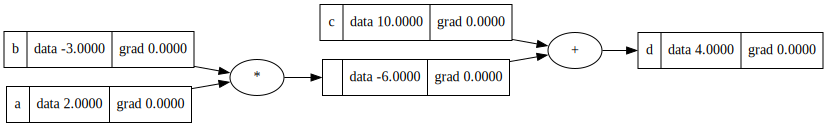

In [285]:
draw_dot(d)

Notice that all the gradients are zero by default.

### Dummy Loss Function

Let us define a dummy loss function that represents the loss of our model from a forward pass. 

$$
\mathcal{L} = d \times f = (e+c) \times f = \left(\overbrace{\underbrace{a \times b}_{\text{e}} + c}^{\text{d}}\right) \times f
$$

to compute the gradient of the loss function $\mathcal{L}$ with respect to all of the input variables $a$, $b$, $c$, $d$, $e$, and $f$, we can use the chain rule of differentiation. The chain rule states that if we have a function $y = f(g(x))$, then its derivative is given by:

$$\frac{dy}{dx} = \frac{df}{dg} \times \frac{dg}{dx}$$

In our case, we have the loss function $\mathcal{L}$ defined as:

$$\mathcal{L} = d \times f = (e+c) \times f = \left(a \times b + c\right) \times f$$

where $d = e + c$ and $e = a \times b$. To compute the gradient of $\mathcal{L}$ with respect to all of the input variables, we can use the chain rule as follows:

$$\frac{\partial \mathcal{L}}{\partial f} = d = a \times b + c$$


$$\frac{\partial \mathcal{L}}{\partial a} = \frac{\partial \mathcal{L}}{\partial e} \times \frac{\partial e}{\partial a} = f \times b$$

$$\frac{\partial \mathcal{L}}{\partial b} = \frac{\partial \mathcal{L}}{\partial e} \times \frac{\partial e}{\partial b} = f \times a$$

$$\frac{\partial \mathcal{L}}{\partial c} = \frac{\partial \mathcal{L}}{\partial d} \times \frac{\partial d}{\partial c} = f$$

$$\frac{\partial \mathcal{L}}{\partial d} = f$$

$$\frac{\partial \mathcal{L}}{\partial e} = \frac{\partial \mathcal{L}}{\partial d} \times \frac{\partial d}{\partial e} = f$$



In the above equations, we use the fact that $\frac{\partial d}{\partial c} = 1$ since $d$ is a linear combination of $c$, and $\frac{\partial d}{\partial e} = 1$ since $d$ is a linear combination of $e$.

In code:

```python
def loss(a, b, c, d, e, f) -> float:
    e = a + b
    d = e + c
    L = d * f
    return L
```

In [254]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L

Value(data=-8.0)

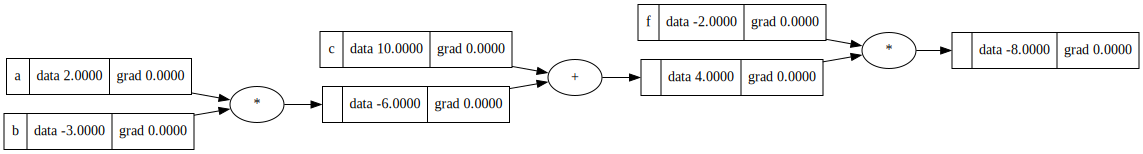

In [286]:
draw_dot(L)

In [289]:
def lol(change_which: str = "L", h: float = 0.001):
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    if change_which == "a":
        a.data += h
    b = Value(-3.0, label="b")
    if change_which == "b":
        b.data += h
    c = Value(10.0, label="c")
    if change_which == "c":
        c.data += h
    e = a * b
    e.label = "e"
    if change_which == "e":
        e.data += h
        
    d = e + c
    d.label = "d"
    if change_which == "d":
        d.data += h
    f = Value(-2.0, label="f")
    if change_which == "f":
        f.data += h
    L = d * f
    if change_which == "L":
        L.data += h
    L.label = "L"
    L2 = L.data
    
    derivative = (L2 - L1) / h
    print(f"derivative of L w.r.t. {change_which} is {derivative}")
    return derivative

Based on the diagram above, we have all the info we need for forward pass, and now it is time
to do the backprop, which is to populate the gradients of the loss function with respect to
each variable. 

`L`: We first ask ourselves, for the given input values at $a=2, b=-3$ and $c=10$, what is the derivative 
of the loss function $\mathcal{L}$ with respect to itself?

You just need to visualize if I add/shift a small number $h=0.001$ to $\mathcal{L} = \left(\overbrace{\underbrace{a \times b}_{\text{e}} + c}^{\text{d}}\right) \times f$, this is just proportional
to the gradient of $\mathcal{L}$ with respect to itself. So the gradient of $\mathcal{L}$ with respect to itself is 1.

In [290]:
_ = lol("L", 0.001)

# set the gradient of L to 1
L.grad = 1.0

derivative of L w.r.t. L is 1.000000000000334


$\frac{\partial \mathcal{L}}{\partial f}$: We then ask ourselves, for the given input values at $a=2, b=-3$ and $c=10$, what is the derivative of the loss function $\mathcal{L}$ with respect to $f$?

$$\frac{\partial \mathcal{L}}{\partial f} = d = a \times b + c$$

This is easy to see since $\mathcal{L} = d \times f$ and differentiating with respect to $f$ while
holding $d$ constant yields us $d$.

We can further convince ourselves by seeing the formula:

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial f} &= \lim_{h \to 0} \frac{\mathcal{L}(a, b, c, d, e, f+h) - \mathcal{L}(a, b, c, d, e, f)}{h} \\
&= \lim_{h \to 0} \frac{\mathcal{L}(f+h) - \mathcal{L}(f)}{h} \\
&= \lim_{h \to 0} \frac{d \times (f+h) - d \times f}{h} \\
&= \lim_{h \to 0} \frac{d \times h}{h} \\
&= d
\end{aligned}
$$

And we can see that for the values of $a=2, b=-3$, $c=10$ and $f=-2$, the value of $d = a \times b + c = 2 \times (-3) + 10 = 4$, so 

$$
\frac{\partial \mathcal{L}}{\partial f} = d = 4
$$

We verify below.

In [291]:
_ = lol("f", 0.001)

derivative of L w.r.t. f is 3.9999999999995595


We update our global variable `f`'s `grad` attribute to be 4.

In [294]:
f.grad = 4

$$
\frac{\partial \mathcal{L}}{\partial d}=f
$$

To derive this, we can first notice that $\mathcal{L} = d \times f$, so we can write:

$$
\frac{\partial \mathcal{L}}{\partial d}=\frac{\partial}{\partial d}(d \times f)=f \frac{\partial d}{\partial d}=f
$$

We can use the same method as above to verify this:

$$
\begin{aligned}
\frac{\partial \mathcal{L}}{\partial d} &= \lim_{h \to 0} \frac{\mathcal{L}(a, b, c, d+h, e, f) - \mathcal{L}(a, b, c, d, e, f)}{h} \\
&= \lim_{h \to 0} \frac{\mathcal{L}(d+h) - \mathcal{L}(d)}{h} \\
&= \lim_{h \to 0} \frac{(d+h) \times f - d \times f}{h} \\
&= \lim_{h \to 0} \frac{f \times h}{h} \\
&= f
\end{aligned}
$$

Therefore, with the given values of $a=2, b=-3$, $c=10$ and $f=-2$, we have:

$$
\frac{\partial \mathcal{L}}{\partial d}=f=-2
$$

In [293]:
_ = lol("d", 0.001)

derivative of L w.r.t. d is -2.000000000000668


We update our global variable `d`'s `grad` attribute to be $-2$.

In [295]:
d.grad = -2

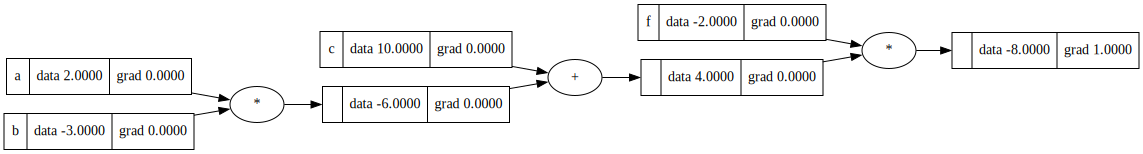

In [296]:
draw_dot(L)

d

Let's start with:



Next, we can find:

$$
\frac{\partial \mathcal{L}}{\partial c}=\frac{\partial}{\partial c}(d \times f)=\frac{\partial d}{\partial c} \times f=1 \times f=f
$$

Here, we used the fact that $\frac{\partial d}{\partial c} = 1$, since $c$ appears linearly in the expression for $d$.

Moving on, we have:

$$
\frac{\partial \mathcal{L}}{\partial b}=\frac{\partial}{\partial b}(d \times f)=\frac{\partial d}{\partial b} \times f=a \times f
$$

We obtain this by applying the product rule of differentiation, since both $a$ and $b$ appear in the expression for $d$.

In [292]:
_ = lol("d", 0.001)

derivative of L w.r.t. d is -2.000000000000668


### S


In [258]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


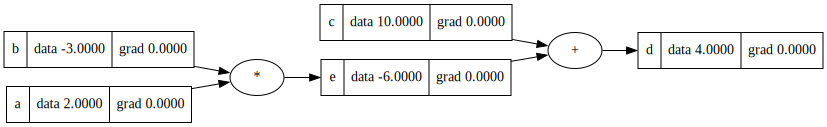

In [259]:
draw_dot(d)

In [260]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L


Value(data=-8.0)

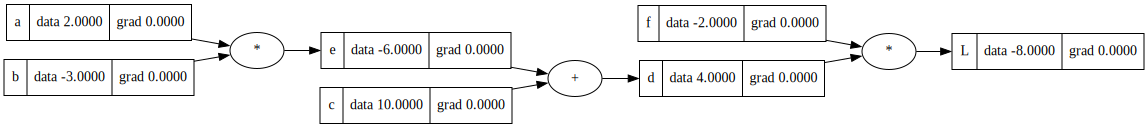

In [261]:
draw_dot(L)

In [262]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-8.0


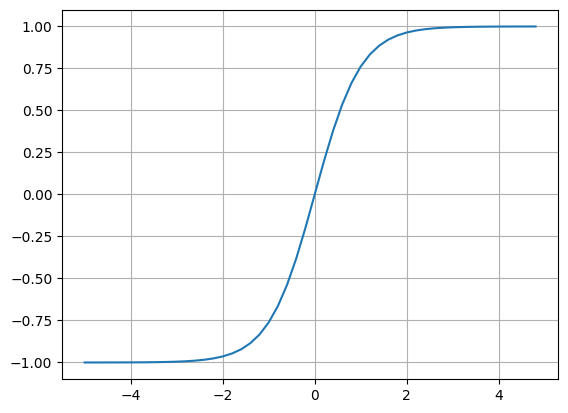

In [263]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [264]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

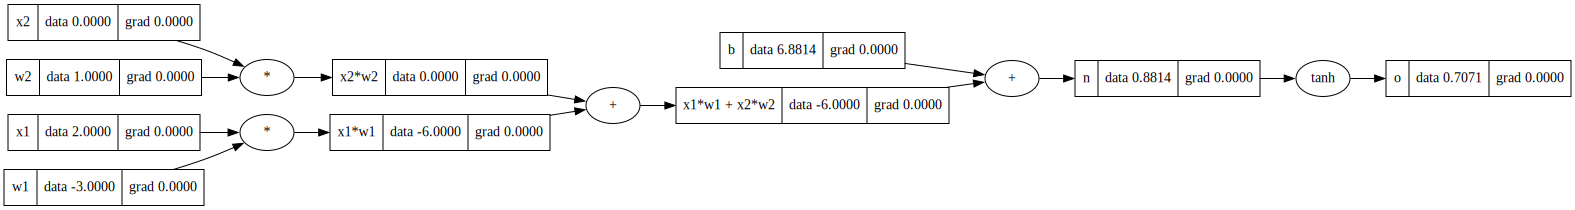

In [265]:
draw_dot(o)

In [266]:
o.backward()

In [267]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [268]:
o.grad = 1.0

In [269]:
o._backward()

In [270]:
n._backward()

In [271]:
b._backward()

In [272]:
x1w1x2w2._backward()

In [273]:
x2w2._backward()
x1w1._backward()

In [274]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [275]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [276]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [277]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [278]:
n.grad = 0.5

In [279]:
o.grad = 1.0

In [280]:
1 - o.data**2

0.4999999999999999

In [281]:
# o = tanh(n)
# do/dn = 1 - o**2

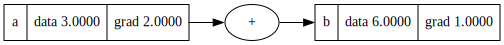

In [282]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

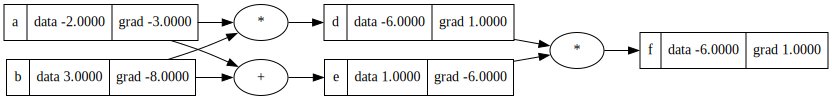

In [283]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)